# Imports

In [1]:
# Configs
%load_ext autoreload
%autoreload 3
## other standard packages
import sys
## Env variables and preparation stuffs
sys.path.insert(0, "../")
from src_code.data_utils.dataset import GridDataset
from src_code.data_utils.dataset_utils import CellType

# Dataset
class CellType(Enum):

    FREE_CELL = 1  # Represents free space
    WALL = 2       # Represens a wall
    START = 3      # Represents the start position
    GOAL = 4       # Represents the goal position

In [2]:
# cell size in the size of the grid measured in pixels
dataset = GridDataset(grid_size=5, seed = 42, wall_symbol="#", free_symbol=".", cell_size=20)
img_rgb1, ascii_inp1, path1 = dataset[0]


In [3]:
img_rgb2, ascii_inp2, path2 = dataset[1]

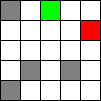

In [4]:
img_rgb2

In [5]:
print(ascii_inp1)

. . G . . 
. . . . # 
# # . . . 
. . # S # 
# . . . . 



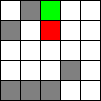

In [12]:
dataset[20][0]

In [9]:
for i in range(1000):
    dataset[i][0]